In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#location of the training data
data_location =  "/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle"
#copy dataloader
#!cp ..content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/data_loader.py .

#imports
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

#custom imports
import sys
import os

py_file_location = "/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/"
sys.path.append(os.path.abspath(py_file_location))
import data_loader
from data_loader import FlickrDataset,get_data_loader

In [ ]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""

    #unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))


    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
#Initiate the Dataset and Dataloader

#setting the constants
data_location =  "/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle"
BATCH_SIZE = 256
# BATCH_SIZE = 6
NUM_WORKER = 4

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))

])
"""
    Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images. If you want to train
    from scratch on your own dataset, you can calculate the new mean and std. Otherwise, using the Imagenet pretrianed model with its own mean and std is recommended.
"""

#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    #caption_file = data_location+"/captions.txt",# gai
    caption_file = "/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/85_percent_train_set.txt",
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [ ]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)

        self.A = nn.Linear(attention_dim,1)




    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)

        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)


        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)

        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)

        return alpha,attention_weights


In [ ]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()

        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)


        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)


        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)



    def forward(self, features, captions):

        #vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds, alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)


        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)


            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


In [ ]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [ ]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/attention_model_state.pth')

In [ ]:
num_epochs = 40
print_every = 100

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            model.train()

    #save the latest model
    save_model(model,epoch)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# load saved model
"""
def load_model(file_path):
    # Load the saved model state
    model_state = torch.load(file_path)

    # Define your model architecture
    model = model.model_state(
        embed_size=model_state['embed_size'],
        vocab_size=model_state['vocab_size'],
        attention_dim=model_state['attention_dim'],
        encoder_dim=model_state['encoder_dim'],
        decoder_dim=model_state['decoder_dim']
    )

    # Load the model state dictionary
    model.load_state_dict(model_state['state_dict'])

    # Other model-specific configurations
    num_epochs = model_state['num_epochs']

    return model, num_epochs

saved_model_path = '/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/attention_model_state.pth'
model, loaded_num_epochs = load_model(saved_model_path)"""


"\ndef load_model(file_path):\n    # Load the saved model state\n    model_state = torch.load(file_path)\n\n    # Define your model architecture\n    model = model.model_state(\n        embed_size=model_state['embed_size'],\n        vocab_size=model_state['vocab_size'],\n        attention_dim=model_state['attention_dim'],\n        encoder_dim=model_state['encoder_dim'],\n        decoder_dim=model_state['decoder_dim']\n    )\n\n    # Load the model state dictionary\n    model.load_state_dict(model_state['state_dict'])\n\n    # Other model-specific configurations\n    num_epochs = model_state['num_epochs']\n\n    return model, num_epochs\n\nsaved_model_path = '/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/attention_model_state.pth'\nmodel, loaded_num_epochs = load_model(saved_model_path)"

In [ ]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)

    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)

        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())


    plt.tight_layout()
    plt.show()

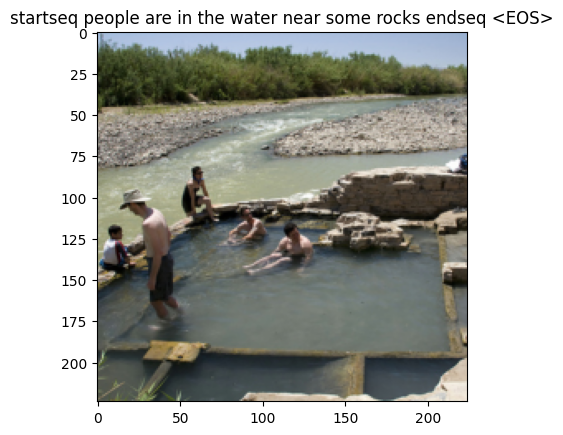

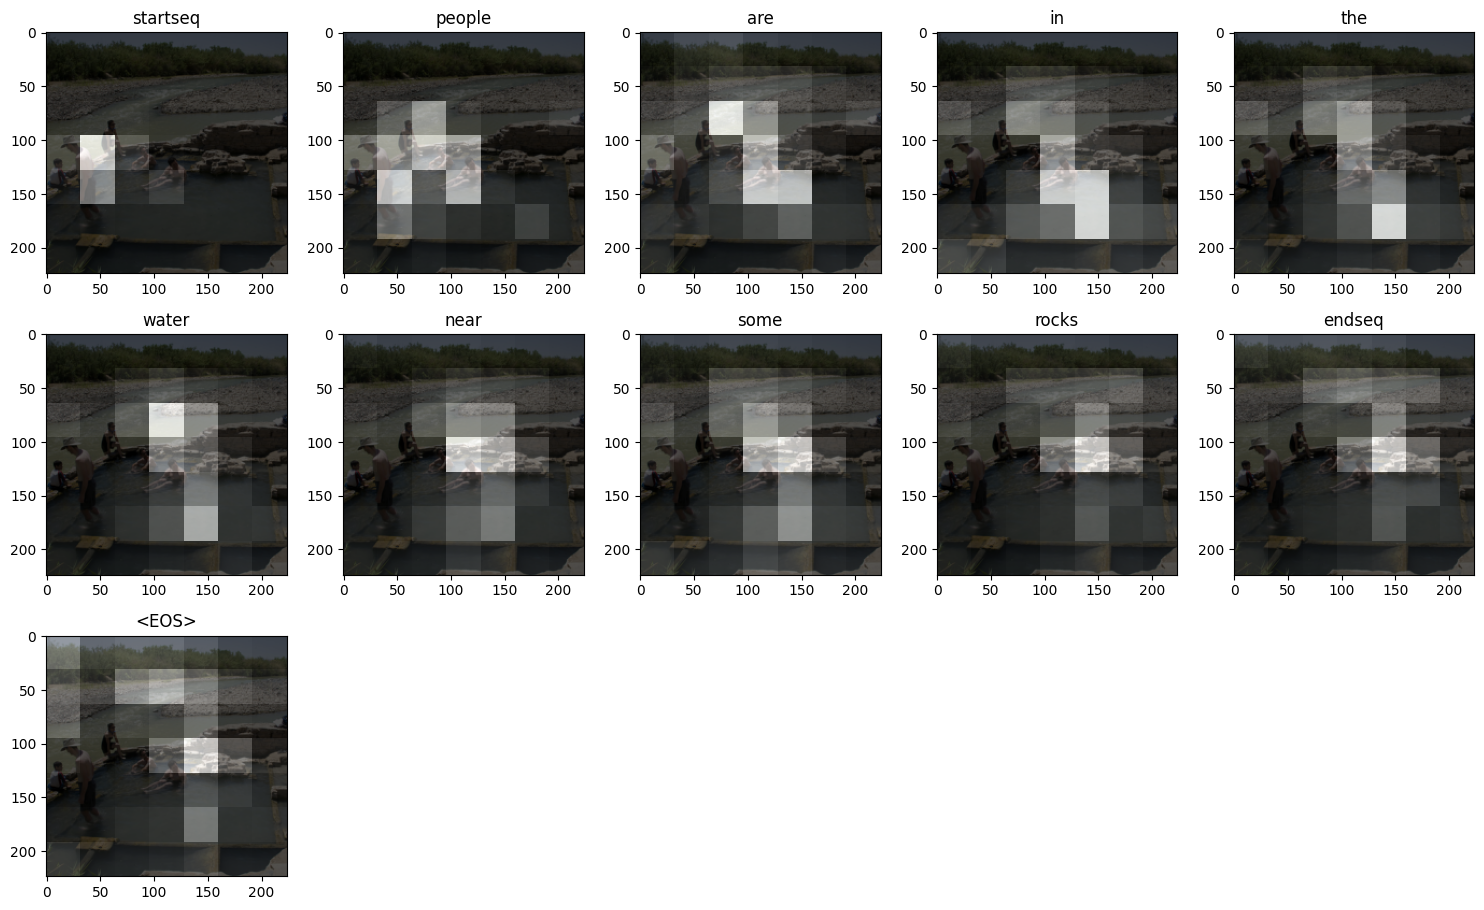

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

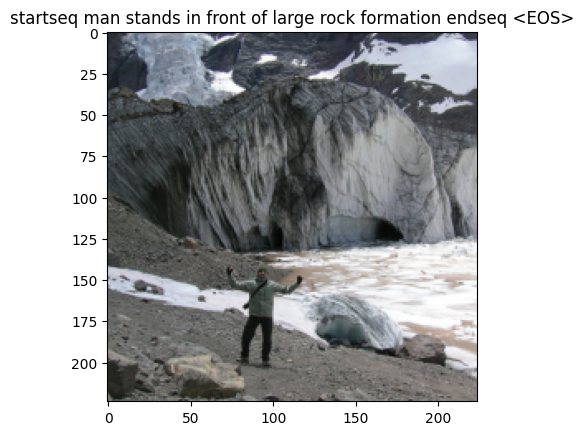

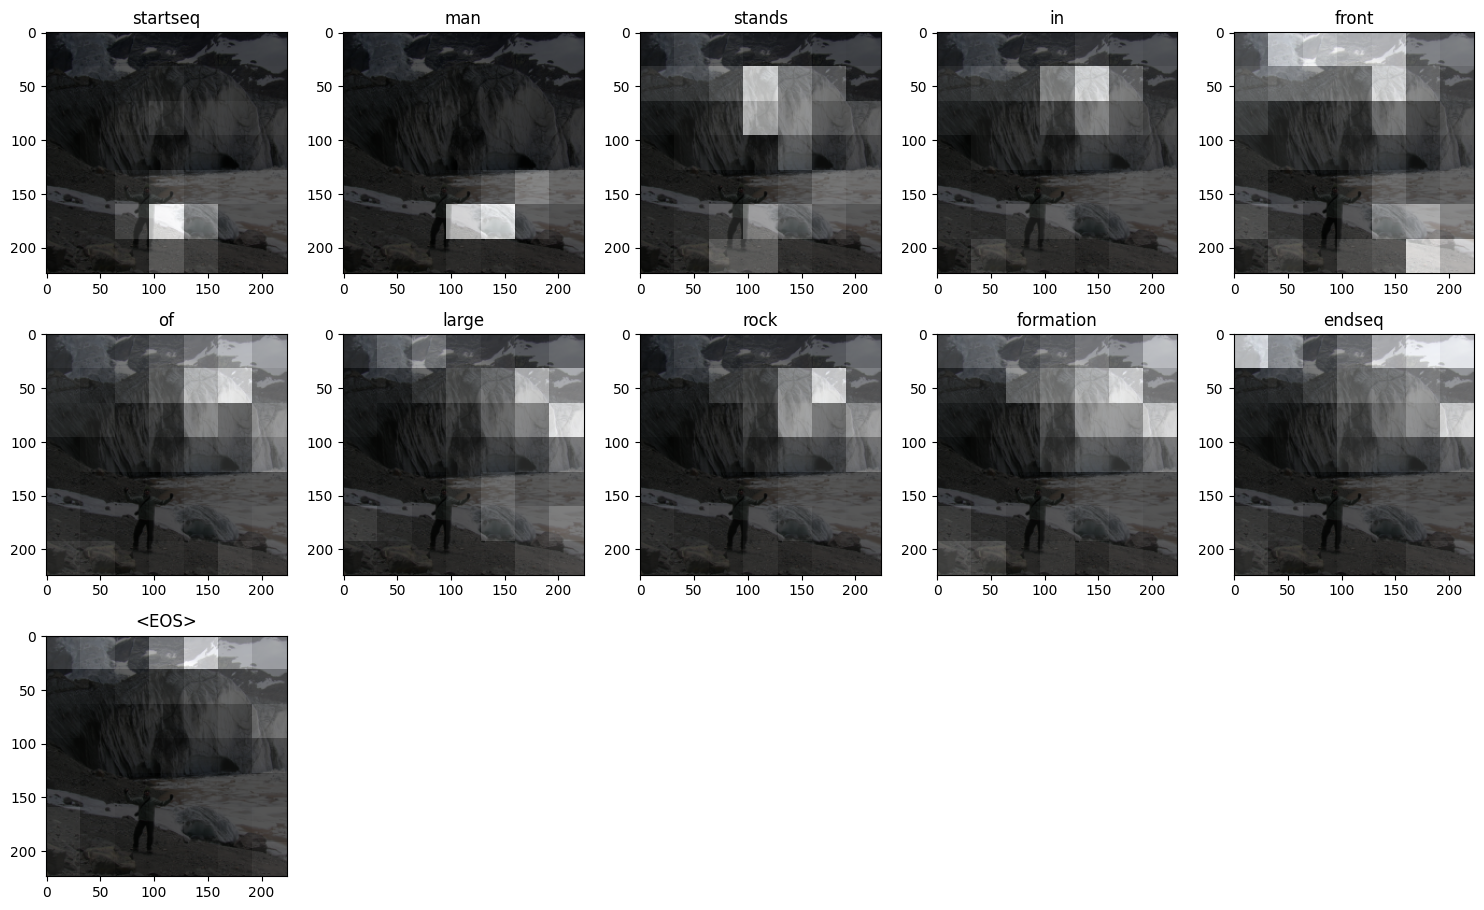

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

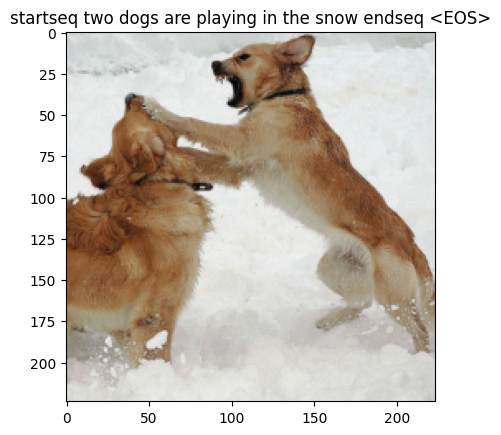

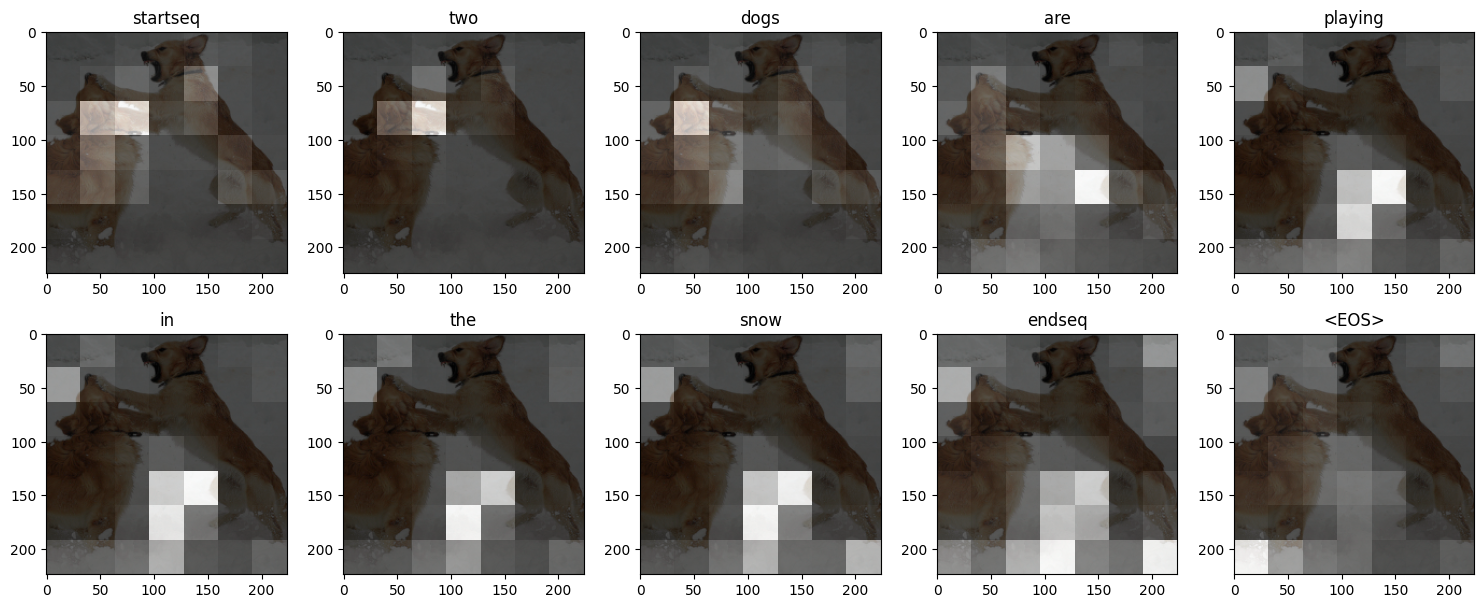

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

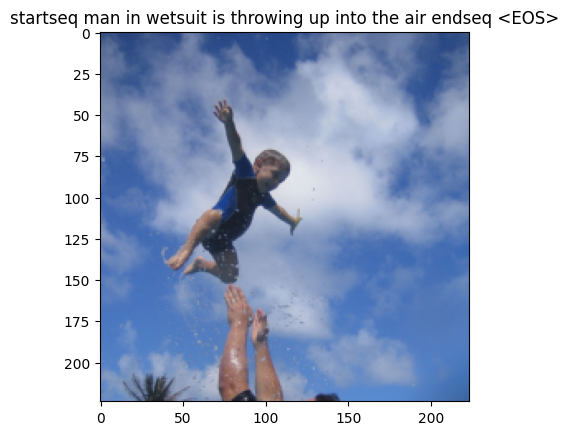

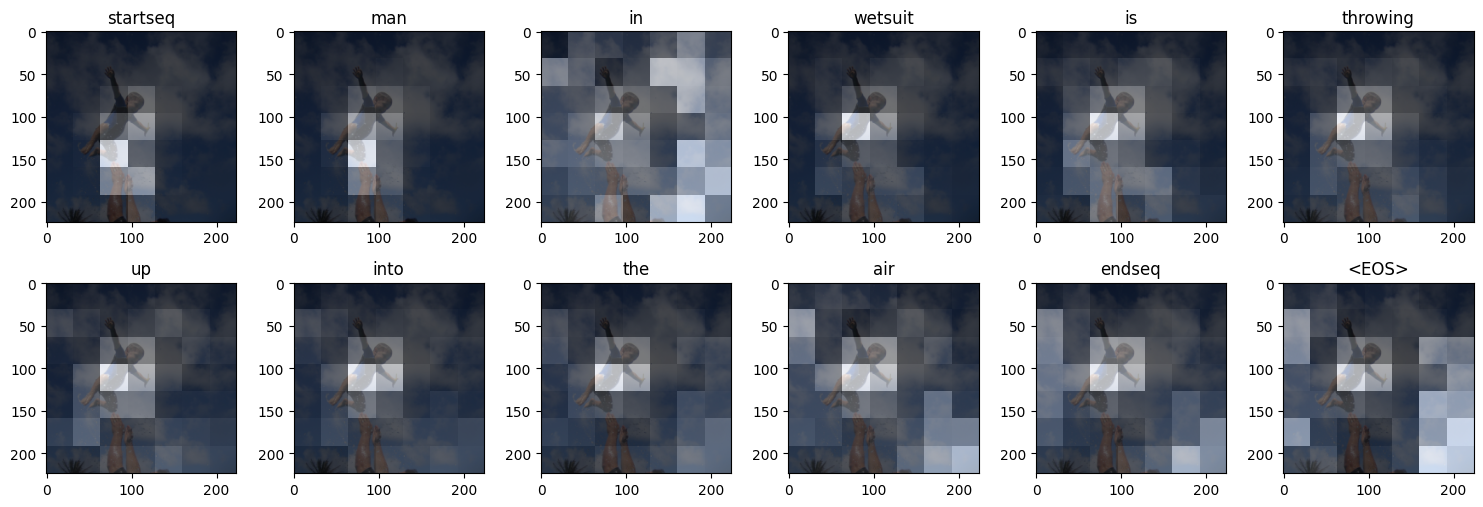

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
#while True:pass

In [ ]:
test_dataset =  FlickrDataset(
    root_dir = "/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images",
    caption_file = "/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/15_percent_test_set.txt",
    transform=transforms
)
test_data_loader = get_data_loader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)

In [ ]:
def get_captions_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        #show_image(features_tensors[0],title=caption)

    return caption,alphas

In [ ]:
test_data_iter = iter(test_data_loader)
images, _ = next(test_data_iter)
num_samples = images.size(0)
all_captions = []  # List to store all generated captions
all_alphas = []
for i in range(num_samples):
    img = images[i].detach().clone()
    img_copy = img.clone()
    captions, alphas = get_captions_from(img.unsqueeze(0))
    all_captions.append(captions)
    all_alphas.append(alphas)

In [ ]:
len(all_captions)

256

In [ ]:
image_id_caption_map = {}
with open('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/15_percent_test_set.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(',')  # Assuming a tab-separated format: image_id\tcaption
        #print(parts)
        if len(parts) == 3:
            _ ,image_id, caption = parts
            image_id_caption_map[image_id] = caption

In [ ]:
image_id_caption_map

{'image': 'caption',
 '3688858505_e8afd1475d.jpg': 'startseq woman in green dress being observed endseq',
 '3689355450_fd559b816d.jpg': 'startseq the person wearing flannel shorts is jumping over fountain endseq',
 '368954110_821ccf005c.jpg': 'startseq three young girls are sitting on the lawn endseq',
 '3689727848_b53f931130.jpg': 'startseq the man is leaping off of the pool deck to catch football endseq',
 '3689975998_72f50b6d91.jpg': 'startseq woman with long black hair and white shirt is running up the sand and tall weeds endseq',
 '3690107455_0fdb4ecee7.jpg': 'startseq woman walking on the rocks endseq',
 '3690159129_93ba49ea18.jpg': 'startseq rollerblader pauses at the top of skate ramp endseq',
 '3690189273_927d42ff43.jpg': 'startseq woman jogger endseq',
 '3690348036_a01f243fb0.jpg': 'startseq the young man is performing bicycle trick high in the air endseq',
 '3690425778_3b390b3ea5.jpg': 'startseq the person wearing shorts and shirt is jumping off dock into the water endseq',


In [ ]:
del image_id_caption_map["image"]

In [ ]:
from PIL import Image

In [ ]:
all_generated_captions = {}
for image_id, caption in image_id_caption_map.items():
    # Load and preprocess the image using the image ID
    image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images',image_id)
    img = Image.open(image_path)
    img = transforms(img)

    # Generate captions for the image
    captions, alphas = get_captions_from(img.unsqueeze(0))  # Assuming get_caps_from generates captions

    all_generated_captions[image_id] = {
        'original_caption': caption,
        'generated_captions': captions,
        'alphas':alphas
    }

In [ ]:
all_generated_captions

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
import numpy as np
image_ids = []
original_captions = []
generated_captions = []
alphas = []
for image_id, values in all_generated_captions.items():
    image_ids.append(image_id)
    original_captions.append(values['original_caption'])
    generated_captions.append(values['generated_captions'])
    alphas.append(values['alphas'])

data = {
    'Image ID': image_ids,
    'Original Caption': original_captions,
    'Generated Caption': generated_captions,
    'Alphas': alphas,
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df

Image ID  \
0     3688858505_e8afd1475d.jpg   
1     3689355450_fd559b816d.jpg   
2      368954110_821ccf005c.jpg   
3     3689727848_b53f931130.jpg   
4     3689975998_72f50b6d91.jpg   
...                         ...   
1209   990890291_afc72be141.jpg   
1210    99171998_7cc800ceef.jpg   
1211    99679241_adc853a5c0.jpg   
1212   997338199_7343367d7f.jpg   
1213   997722733_0cb5439472.jpg   

                                       Original Caption  \
0     startseq woman in green dress being observed e...   
1     startseq the person wearing flannel shorts is ...   
2     startseq three young girls are sitting on the ...   
3     startseq the man is leaping off of the pool de...   
4     startseq woman with long black hair and white ...   
...                                                 ...   
1209  startseq man on bicycle riding on only one whe...   
1210  startseq five people are sitting together in t...   
1211  startseq white crane stands tall as it looks o...   
1212  startseq woman writing on pad in room with gol...   
1213  startseq rock climber practices on rock climbi...   

                                      Generated Caption  \
0     startseq the little girl in the dress is holdi...   
1     startseq young boy is jumping off of fountain ...   
2     startseq two young girls are playing in the gr...   
3        startseq boy is jumping into pool endseq <EOS>   
4     startseq man in blue <UNK> <UNK> <UNK> <UNK> <...   
...                                                 ...   
1209  startseq woman in blue and white helmet is rid...   
1210  startseq group of people are sledding in snow ...   
1211  startseq bird flying through the water endseq ...   
1212  startseq man sits on wall with <UNK> <UNK> and...   
1213  startseq man in red shirt is climbing up rock ...   

                                                 Alphas  
0     [[[8.1970285e-07, 4.0182413e-06, 5.2841995e-05...  
1     [[[2.7040844e-06, 0.0001562296, 7.198119e-06, ...  
2     [[[1.0810232e-05, 1.4674641e-05, 1.559943e-05,...  
3     [[[2.1307433e-06, 3.1051886e-07, 3.6922776e-07...  
4     [[[4.548393e-06, 0.00013775275, 0.0009258136, ...  
...                                                 ...  
1209  [[[4.8262272e-08, 6.885649e-08, 2.0052662e-06,...  
1210  [[[1.9366755e-06, 1.523189e-06, 0.00017183197,...  
1211  [[[1.2060556e-06, 9.785612e-07, 7.816475e-06, ...  
1212  [[[4.613507e-05, 3.476823e-05, 0.00012699765, ...  
1213  [[[4.1688592e-05, 0.00011991626, 0.00064426987...  

[1214 rows x 4 columns]

In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/generated_captions.csv")

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/generated_captions.csv')

In [ ]:
df['Generated Caption'] = df['Generated Caption'].str.replace('<EOS>', '')
# Strip any extra spaces resulting from string removal
df['Generated Caption'] = df['Generated Caption'].str.strip()
# Display the updated DataFrame
df

Unnamed: 0                   Image ID  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3689355450_fd559b816d.jpg   
2              2   368954110_821ccf005c.jpg   
3              3  3689727848_b53f931130.jpg   
4              4  3689975998_72f50b6d91.jpg   
...          ...                        ...   
1209        1209   990890291_afc72be141.jpg   
1210        1210    99171998_7cc800ceef.jpg   
1211        1211    99679241_adc853a5c0.jpg   
1212        1212   997338199_7343367d7f.jpg   
1213        1213   997722733_0cb5439472.jpg   

                                       Original Caption  \
0     startseq woman in green dress being observed e...   
1     startseq the person wearing flannel shorts is ...   
2     startseq three young girls are sitting on the ...   
3     startseq the man is leaping off of the pool de...   
4     startseq woman with long black hair and white ...   
...                                                 ...   
1209  startseq man on bicycle riding on only one whe...   
1210  startseq five people are sitting together in t...   
1211  startseq white crane stands tall as it looks o...   
1212  startseq woman writing on pad in room with gol...   
1213  startseq rock climber practices on rock climbi...   

                                      Generated Caption  \
0     startseq the little girl in the dress is holdi...   
1     startseq young boy is jumping off of fountain ...   
2     startseq two young girls are playing in the gr...   
3              startseq boy is jumping into pool endseq   
4     startseq man in blue <UNK> <UNK> <UNK> <UNK> <...   
...                                                 ...   
1209  startseq woman in blue and white helmet is rid...   
1210  startseq group of people are sledding in snow ...   
1211      startseq bird flying through the water endseq   
1212  startseq man sits on wall with <UNK> <UNK> and...   
1213  startseq man in red shirt is climbing up rock ...   

                                                 Alphas  
0     [array([[8.1970285e-07, 4.0182413e-06, 5.28419...  
1     [array([[2.70408441e-06, 1.56229595e-04, 7.198...  
2     [array([[1.08102322e-05, 1.46746406e-05, 1.559...  
3     [array([[2.1307433e-06, 3.1051886e-07, 3.69227...  
4     [array([[4.5483930e-06, 1.3775275e-04, 9.25813...  
...                                                 ...  
1209  [array([[4.8262272e-08, 6.8856487e-08, 2.00526...  
1210  [array([[1.93667552e-06, 1.52318898e-06, 1.718...  
1211  [array([[1.20605557e-06, 9.78561161e-07, 7.816...  
1212  [array([[4.6135068e-05, 3.4768229e-05, 1.26997...  
1213  [array([[4.16885923e-05, 1.19916258e-04, 6.442...  

[1214 rows x 5 columns]

In [ ]:
Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/15_percent_test_set.csv")
Test_set

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  
0     startseq blond girl in green dress and elabora...  
1     startseq few people with girl standing up in t...  
2              startseq girl is wear green dress endseq  
3     startseq blonde girl wearing green dress stand...  
4     startseq woman in green dress being observed e...  
...                                                 ...  
6065  startseq man in pink shirt climbs rock face en...  
6066  startseq man is rock climbing high in the air ...  
6067  startseq person in red shirt climbing up rock ...  
6068          startseq rock climber in red shirt endseq  
6069  startseq rock climber practices on rock climbi...  

[6070 rows x 3 columns]

In [ ]:
for index,record in df.iterrows():
  for i in range(0,5):
    Test_set.loc[index*5+i,"new_caption"] = record["Generated Caption"]

Test_set

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     startseq blond girl in green dress and elabora...   
1     startseq few people with girl standing up in t...   
2              startseq girl is wear green dress endseq   
3     startseq blonde girl wearing green dress stand...   
4     startseq woman in green dress being observed e...   
...                                                 ...   
6065  startseq man in pink shirt climbs rock face en...   
6066  startseq man is rock climbing high in the air ...   
6067  startseq person in red shirt climbing up rock ...   
6068          startseq rock climber in red shirt endseq   
6069  startseq rock climber practices on rock climbi...   

                                            new_caption  
0     startseq the little girl in the dress is holdi...  
1     startseq the little girl in the dress is holdi...  
2     startseq the little girl in the dress is holdi...  
3     startseq the little girl in the dress is holdi...  
4     startseq the little girl in the dress is holdi...  
...                                                 ...  
6065  startseq man in red shirt is climbing up rock ...  
6066  startseq man in red shirt is climbing up rock ...  
6067  startseq man in red shirt is climbing up rock ...  
6068  startseq man in red shirt is climbing up rock ...  
6069  startseq man in red shirt is climbing up rock ...  

[6070 rows x 4 columns]

In [ ]:
Test_set['caption'] = Test_set['caption'].str.replace('startseq', '')
Test_set['caption'] = Test_set['caption'].str.replace('endseq', '')
Test_set['caption'] = Test_set['caption'].str.strip()

Test_set['new_caption'] = Test_set['new_caption'].str.replace('startseq', '')
Test_set['new_caption'] = Test_set['new_caption'].str.replace('endseq', '')
Test_set['new_caption'] = Test_set['new_caption'].str.strip()
Test_set

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     blond girl in green dress and elaborate gold n...   
1     few people with girl standing up in the center...   
2                              girl is wear green dress   
3              blonde girl wearing green dress standing   
4                   woman in green dress being observed   
...                                                 ...   
6065                 man in pink shirt climbs rock face   
6066               man is rock climbing high in the air   
6067  person in red shirt climbing up rock face cove...   
6068                          rock climber in red shirt   
6069       rock climber practices on rock climbing wall   

                                            new_caption  
0     the little girl in the dress is holding the gi...  
1     the little girl in the dress is holding the gi...  
2     the little girl in the dress is holding the gi...  
3     the little girl in the dress is holding the gi...  
4     the little girl in the dress is holding the gi...  
...                                                 ...  
6065          man in red shirt is climbing up rock face  
6066          man in red shirt is climbing up rock face  
6067          man in red shirt is climbing up rock face  
6068          man in red shirt is climbing up rock face  
6069          man in red shirt is climbing up rock face  

[6070 rows x 4 columns]

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=c08b3010ab2210f50590144c2b4fe6c54c49ce07a93c3a2f22237df211c9bb96
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
#lan_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
lan_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [ ]:
for index,record in Test_set.iterrows():
  sentences = []
  sentences.append(record["caption"])
  sentences.append(record["new_caption"])
  #print(sentences)
  embeddings = lan_model.encode(sentences)
  sim = util.cos_sim(embeddings[0], embeddings[1])
  Test_set.loc[index,'sim_score'] = round(sim.tolist()[0][0],4)
Test_set

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     blond girl in green dress and elaborate gold n...   
1     few people with girl standing up in the center...   
2                              girl is wear green dress   
3              blonde girl wearing green dress standing   
4                   woman in green dress being observed   
...                                                 ...   
6065                 man in pink shirt climbs rock face   
6066               man is rock climbing high in the air   
6067  person in red shirt climbing up rock face cove...   
6068                          rock climber in red shirt   
6069       rock climber practices on rock climbing wall   

                                            new_caption  sim_score  
0     the little girl in the dress is holding the gi...     0.6528  
1     the little girl in the dress is holding the gi...     0.5888  
2     the little girl in the dress is holding the gi...     0.5723  
3     the little girl in the dress is holding the gi...     0.6058  
4     the little girl in the dress is holding the gi...     0.6072  
...                                                 ...        ...  
6065          man in red shirt is climbing up rock face     0.9027  
6066          man in red shirt is climbing up rock face     0.8834  
6067          man in red shirt is climbing up rock face     0.9168  
6068          man in red shirt is climbing up rock face     0.8547  
6069          man in red shirt is climbing up rock face     0.7042  

[6070 rows x 5 columns]

In [ ]:
Test_set.to_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/Test_set_sim.csv")

In [ ]:
count_row = Test_set.shape[0]
total_sim = 0
for index,record in Test_set.iterrows():
  total_sim+=record["sim_score"]
average_score = round((total_sim/count_row), 4)
print("the average similarity socre for test set using attenstion as encoder is " + str(average_score))

the average similarity socre for test set using attenstion as encoder is 0.587


### BLEU

In [ ]:
import pandas as pd
Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/Test_set_sim.csv")

In [ ]:
Test_set

Unnamed: 0.1  Unnamed: 0                      image  \
0                0           0  3688858505_e8afd1475d.jpg   
1                1           1  3688858505_e8afd1475d.jpg   
2                2           2  3688858505_e8afd1475d.jpg   
3                3           3  3688858505_e8afd1475d.jpg   
4                4           4  3688858505_e8afd1475d.jpg   
...            ...         ...                        ...   
6065          6065        6065   997722733_0cb5439472.jpg   
6066          6066        6066   997722733_0cb5439472.jpg   
6067          6067        6067   997722733_0cb5439472.jpg   
6068          6068        6068   997722733_0cb5439472.jpg   
6069          6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     blond girl in green dress and elaborate gold n...   
1     few people with girl standing up in the center...   
2                              girl is wear green dress   
3              blonde girl wearing green dress standing   
4                   woman in green dress being observed   
...                                                 ...   
6065                 man in pink shirt climbs rock face   
6066               man is rock climbing high in the air   
6067  person in red shirt climbing up rock face cove...   
6068                          rock climber in red shirt   
6069       rock climber practices on rock climbing wall   

                                            new_caption  sim_score  
0     startseq the little girl in the dress is holdi...     0.2609  
1     startseq the little girl in the dress is holdi...     0.3581  
2     startseq the little girl in the dress is holdi...     0.3362  
3     startseq the little girl in the dress is holdi...     0.3012  
4     startseq the little girl in the dress is holdi...     0.1643  
...                                                 ...        ...  
6065  startseq man in red shirt is climbing up rock ...     0.7114  
6066  startseq man in red shirt is climbing up rock ...     0.6408  
6067  startseq man in red shirt is climbing up rock ...     0.7603  
6068  startseq man in red shirt is climbing up rock ...     0.7959  
6069  startseq man in red shirt is climbing up rock ...     0.6633  

[6070 rows x 6 columns]

In [ ]:
import re

column_name = 'caption'

# Create a new DataFrame to store the results
result_data = []

# Iterate through the DataFrame using iterrows
chunk_size = 5
for index, row in Test_set.iterrows():
    if index % chunk_size == 0:
        start_index = index
        end_index = min(index + chunk_size, len(Test_set))
        #chunk = Test_set.loc[start_index:end_index - 1, column_name]
        #combined_vocabs = ' '.join(set(re.findall(r'\b\w+\b', ' '.join(chunk))))
        Fir_caption = Test_set.loc[start_index, column_name]
        sec_caption = Test_set.loc[start_index+1, column_name]
        thr_caption = Test_set.loc[start_index+2, column_name]
        fou_caption = Test_set.loc[start_index+3, column_name]
        fif_caption = Test_set.loc[start_index+4, column_name]
        #result_data.append({'image': Test_set.loc[start_index,"image"], 'Combined_Vocabs': combined_vocabs,'new_caption':Test_set.loc[start_index,"new_caption"]})
        result_data.append({'image': Test_set.loc[start_index,"image"], 'First_caption': Fir_caption, 'Second_caption': sec_caption,
                            'Thrid_caption': thr_caption,'Forth_caption': fou_caption,'Fifth_caption': fif_caption, 'new_caption':Test_set.loc[start_index,"new_caption"]})
# Create the result DataFrame
result_df = pd.DataFrame(result_data)

In [ ]:
result_df

image  \
0     3688858505_e8afd1475d.jpg   
1     3689355450_fd559b816d.jpg   
2      368954110_821ccf005c.jpg   
3     3689727848_b53f931130.jpg   
4     3689975998_72f50b6d91.jpg   
...                         ...   
1209   990890291_afc72be141.jpg   
1210    99171998_7cc800ceef.jpg   
1211    99679241_adc853a5c0.jpg   
1212   997338199_7343367d7f.jpg   
1213   997722733_0cb5439472.jpg   

                                          First_caption  \
0     blond girl in green dress and elaborate gold n...   
1     boy wearing plaid shorts jumping over big wate...   
2     girl in purple top holds toddler between herse...   
3       boy tries to catch ball while jumping into pool   
4                      an asian girl is running outside   
...                                                 ...   
1209    man does wheelie on his bicycle on the sidewalk   
1210             group is sitting around snowy crevasse   
1211  grey bird stands majestically on beach while w...   
1212                    person stands near golden walls   
1213                 man in pink shirt climbs rock face   

                                         Second_caption  \
0     few people with girl standing up in the center...   
1          man in plaid shorts is jumping over fountain   
2                       three children sit on the grass   
3          male dives for ball that 's flying over pool   
4               an asian woman is running on rocky path   
...                                                 ...   
1209              man is doing wheelie on mountain bike   
1210            group of people sit atop snowy mountain   
1211        large bird stands in the water on the beach   
1212              woman behind scrolled wall is writing   
1213               man is rock climbing high in the air   

                                          Thrid_caption  \
0                              girl is wear green dress   
1                    man is jumping over water fountain   
2        three little children are sitting in the grass   
3                       male jumping into swimming pool   
4                        woman runs on chalk white path   
...                                                 ...   
1209           man on bicycle is on only the back wheel   
1210  group of people sit in the snow overlooking mo...   
1211  tall bird is standing on the sand beside the o...   
1212          woman standing near decorated wall writes   
1213  person in red shirt climbing up rock face cove...   

                                          Forth_caption  \
0              blonde girl wearing green dress standing   
1                         man jumps near water fountain   
2           three little girls are sitting on the grass   
3             man dives into swimming pool at the hotel   
4                               woman runs on the beach   
...                                                 ...   
1209  asian man in orange hat is popping wheelie on ...   
1210                five children getting ready to sled   
1211           water bird standing at the ocean 's edge   
1212         the walls are covered in gold and patterns   
1213                          rock climber in red shirt   

                                          Fifth_caption  \
0                   woman in green dress being observed   
1     the person wearing flannel shorts is jumping o...   
2             three young girls are sitting on the lawn   
3     the man is leaping off of the pool deck to cat...   
4     woman with long black hair and white shirt is ...   
...                                                 ...   
1209            man on bicycle riding on only one wheel   
1210       five people are sitting together in the snow   
1211  white crane stands tall as it looks out upon t...   
1212  woman writing on pad in room with gold decorat...   
1213       rock climber practices on rock climbing wall   

                                            new_caption  
0 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for index, row in result_df.iterrows():
  reference = [list(row["First_caption"].split(" ")), list(row["Second_caption"].split(" ")), list(row["Thrid_caption"].split(" ")), list(row["Forth_caption"].split(" ")) ,list(row["Fifth_caption"].split(" "))]
  #print(reference)
  candidate = list(row["new_caption"].split(" "))
  n_1_gram_bleu = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
  n_2_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
  n_3_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
  n_4_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))
  culmulated_4_gram_bleu = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
  result_df.loc[index,"1_gram_bleu"] = n_1_gram_bleu
  result_df.loc[index,"2_gram_bleu"] = n_2_gram_bleu
  result_df.loc[index,"3_gram_bleu"] = n_3_gram_bleu
  result_df.loc[index,"4_gram_bleu"] = n_4_gram_bleu
  result_df.loc[index,"culmulated_4_gram_bleu"] = culmulated_4_gram_bleu

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
result_df.to_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/bleu_score.csv")

In [ ]:
result_df

image  \
0     3688858505_e8afd1475d.jpg   
1     3689355450_fd559b816d.jpg   
2      368954110_821ccf005c.jpg   
3     3689727848_b53f931130.jpg   
4     3689975998_72f50b6d91.jpg   
...                         ...   
1209   990890291_afc72be141.jpg   
1210    99171998_7cc800ceef.jpg   
1211    99679241_adc853a5c0.jpg   
1212   997338199_7343367d7f.jpg   
1213   997722733_0cb5439472.jpg   

                                          First_caption  \
0     blond girl in green dress and elaborate gold n...   
1     boy wearing plaid shorts jumping over big wate...   
2     girl in purple top holds toddler between herse...   
3       boy tries to catch ball while jumping into pool   
4                      an asian girl is running outside   
...                                                 ...   
1209    man does wheelie on his bicycle on the sidewalk   
1210             group is sitting around snowy crevasse   
1211  grey bird stands majestically on beach while w...   
1212                    person stands near golden walls   
1213                 man in pink shirt climbs rock face   

                                         Second_caption  \
0     few people with girl standing up in the center...   
1          man in plaid shorts is jumping over fountain   
2                       three children sit on the grass   
3          male dives for ball that 's flying over pool   
4               an asian woman is running on rocky path   
...                                                 ...   
1209              man is doing wheelie on mountain bike   
1210            group of people sit atop snowy mountain   
1211        large bird stands in the water on the beach   
1212              woman behind scrolled wall is writing   
1213               man is rock climbing high in the air   

                                          Thrid_caption  \
0                              girl is wear green dress   
1                    man is jumping over water fountain   
2        three little children are sitting in the grass   
3                       male jumping into swimming pool   
4                        woman runs on chalk white path   
...                                                 ...   
1209           man on bicycle is on only the back wheel   
1210  group of people sit in the snow overlooking mo...   
1211  tall bird is standing on the sand beside the o...   
1212          woman standing near decorated wall writes   
1213  person in red shirt climbing up rock face cove...   

                                          Forth_caption  \
0              blonde girl wearing green dress standing   
1                         man jumps near water fountain   
2           three little girls are sitting on the grass   
3             man dives into swimming pool at the hotel   
4                               woman runs on the beach   
...                                                 ...   
1209  asian man in orange hat is popping wheelie on ...   
1210                five children getting ready to sled   
1211           water bird standing at the ocean 's edge   
1212         the walls are covered in gold and patterns   
1213                          rock climber in red shirt   

                                          Fifth_caption  \
0                   woman in green dress being observed   
1     the person wearing flannel shorts is jumping o...   
2             three young girls are sitting on the lawn   
3     the man is leaping off of the pool deck to cat...   
4     woman with long black hair and white shirt is ...   
...                                                 ...   
1209            man on bicycle riding on only one wheel   
1210       five people are sitting together in the snow   
1211  white crane stands tall as it looks out upon t...   
1212  woman writing on pad in room with gold decorat...   
1213       rock climber practices on rock climbing wall   

                                            new_caption  1_g

In [ ]:
bleu_one_mean = round(result_df["1_gram_bleu"].mean(),4)
print("the mean of bleu one gram is " + str(bleu_one_mean))

the mean of bleu one gram is 0.4266


In [ ]:
import pandas as pd
Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Attention_CNN+RNN/Test_set_sim.csv")

In [ ]:
aver_score_sample = 0
test_dataset = pd.DataFrame()
for index,record in Test_set.iterrows():
  if index%5 != 4:
    aver_score_sample+=record["sim_score"]
  else:
    aver_score_sample+=record["sim_score"]
    new_index = index//5
    test_dataset.loc[new_index,"image"] = record["image"]
    test_dataset.loc[new_index,"caption"] = record["caption"]
    test_dataset.loc[new_index,"new_caption"] = record["new_caption"]
    test_dataset.loc[new_index,"avg_sample_sim_socre"] = round(aver_score_sample/5,4)
    aver_score_sample = 0

In [ ]:
max_sample = test_dataset.loc[test_dataset['avg_sample_sim_socre'].idxmax()]
max_sample

image                        526661994_21838fc72c.jpg
caption                    dog runs through the grass
new_caption             two dogs running in the grass
avg_sample_sim_socre                            0.973
Name: 756, dtype: object

In [ ]:
min_sample = test_dataset.loc[test_dataset['avg_sample_sim_socre'].idxmin()]
min_sample

image                                           3729525173_7f984ed776.jpg
caption                 woman sits and reads on the front stoop of her...
new_caption                               young boy jumps off of building
avg_sample_sim_socre                                              -0.0005
Name: 170, dtype: object

In [ ]:
def display_one_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (40 , 40))
    n = 0
    for i in range(1):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
full_max_sample = Test_set.loc[Test_set["image"] == max_sample["image"]]
full_max_sample

Unnamed: 0.1  Unnamed: 0                     image  \
3780          3780        3780  526661994_21838fc72c.jpg   
3781          3781        3781  526661994_21838fc72c.jpg   
3782          3782        3782  526661994_21838fc72c.jpg   
3783          3783        3783  526661994_21838fc72c.jpg   
3784          3784        3784  526661994_21838fc72c.jpg   

                               caption                    new_caption  \
3780  dog is running away in the grass  two dogs running in the grass   
3781              dog running on grass  two dogs running in the grass   
3782     dog running through the grass  two dogs running in the grass   
3783         dog runs across the grass  two dogs running in the grass   
3784        dog runs through the grass  two dogs running in the grass   

      sim_score  
3780     0.9301  
3781     0.9816  
3782     0.9890  
3783     0.9808  
3784     0.9835

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from textwrap import wrap
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

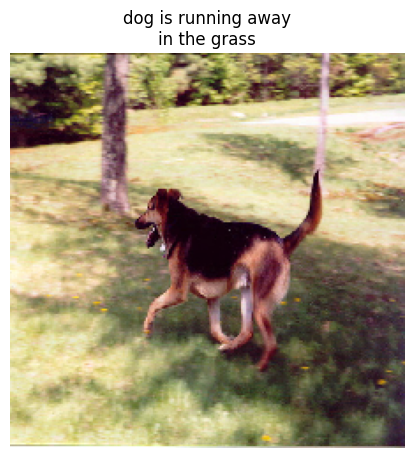

In [ ]:
display_one_images(full_max_sample)

In [ ]:
full_min_sample = Test_set.loc[Test_set["image"] == min_sample["image"]]
full_min_sample

Unnamed: 0.1  Unnamed: 0                      image  \
850           850         850  3729525173_7f984ed776.jpg   
851           851         851  3729525173_7f984ed776.jpg   
852           852         852  3729525173_7f984ed776.jpg   
853           853         853  3729525173_7f984ed776.jpg   
854           854         854  3729525173_7f984ed776.jpg   

                                               caption  \
850           lady sitting on front porch reading book   
851             person sits at doorstep and reads book   
852  woman is reading literature and sitting on the...   
853   woman sits and reads in the stoop of wooden door   
854  woman sits and reads on the front stoop of her...   

                         new_caption  sim_score  
850  young boy jumps off of building    -0.0705  
851  young boy jumps off of building     0.0607  
852  young boy jumps off of building    -0.0153  
853  young boy jumps off of building     0.0259  
854  young boy jumps off of building    -0.0033

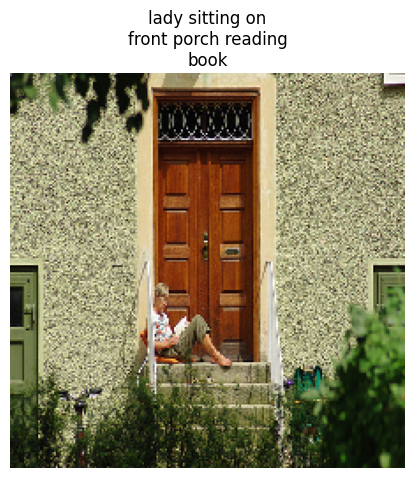

In [ ]:
display_one_images(full_min_sample)

In [ ]:
data = ["526661994_21838fc72c.jpg","94232465_a135df2711.jpg","3713882697_6dd30c7505.jpg", "3729525173_7f984ed776.jpg"]
df_one = pd.DataFrame(data, columns=['image'])
df_one

image
0   526661994_21838fc72c.jpg
1    94232465_a135df2711.jpg
2  3713882697_6dd30c7505.jpg
3  3729525173_7f984ed776.jpg

In [ ]:
def display_four_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(4):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title(temp_df.image[i])
        plt.axis("off")

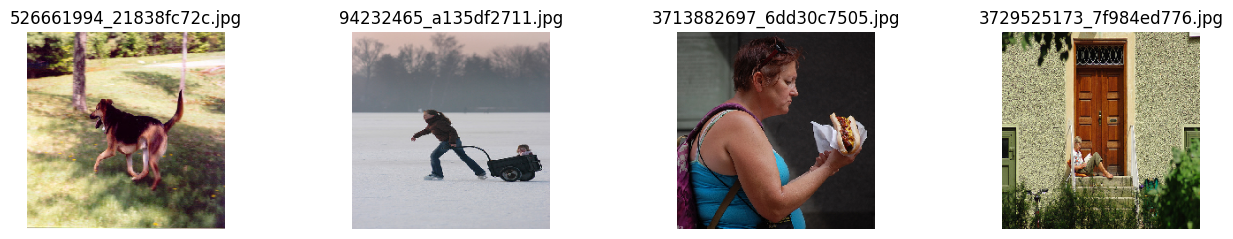

In [ ]:
display_four_images(df_one)